In [1]:
# 파일이름 : MES_CMB_data_generator.ipynb
# 코드설명 : 고무 배합비와 제조실행시스템(MES)에서 얻어진 검사 CMB 데이터에 대한 전처리 및 모델 학습 데이터 세트 생성
# 입/출력 : MES 통합 데이터 (DA측 제공) / MES CMB 데이터 세트(17개)
# 유의 사항 : 물성값이 0인 경우 제외
# 최종수정 : 2023년 11월 27일
# 제 작 자 : 홍민성 (mshong@micube.co.kr), 맹영준 (myj6223@micube.co.kr)
# Copyright : MICUBE Solution, Inc.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
#print(font_list)

# 한글 폰트 설정
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 유니코드 마이너스 사용 설정 (깨지는 문제 방지)

sns.set(font="NanumGothic", # 일반적으로 설치되어 있는 폰트로 변경
        rc={"axes.unicode_minus": False, "figure.figsize": (20, 8)}, # figure size와 unicode_min
        style='darkgrid',
        font_scale=0.8) # 폰트 크기 설정 추가

import pandas as pd
import numpy as np
import matplotlib
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
import os
import koreanize_matplotlib
import pingouin as pg
from tqdm.auto import tqdm

## 1. 데이터 로드 및 분류, 이상치 조정

### 1.1 데이터 로드 및 분류, 점검

In [11]:
mes_full_df=pd.read_pickle('./dataset/(Re)24_sfites_real_mix_data_full.pkl')
total_df=pd.read_pickle('./dataset/clean_lab_mes_dataset.pkl')
total_df=total_df[total_df['type']=='mes']

#### 1.1.1) CMB와 FMB 데이터 분리

In [12]:
mes_part_df = mes_full_df.drop(columns=[col for col in total_df.columns if (col!='type') & (col!='ID')])
mes_part_df

,LOTNO,RUBBER,MECHCD,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,HS_RESULT,SG_RESULT,TS_RESULT,EB_RESULT,MNY_RESULT,REHO_RESULT,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,6_JRCODE,7_JRCODE,8_JRCODE,9_JRCODE,10_JRCODE,11_JRCODE,12_JRCODE,13_JRCODE,14_JRCODE,15_JRCODE,16_JRCODE,17_JRCODE,18_JRCODE,19_JRCODE,20_JRCODE,21_JRCODE,1_PHR,2_PHR,3_PHR,4_PHR,5_PHR,6_PHR,7_PHR,8_PHR,9_PHR,10_PHR,11_PHR,12_PHR,13_PHR,14_PHR,15_PHR,16_PHR,17_PHR,18_PHR,19_PHR,20_PHR,21_PHR,1_PUTGB,2_PUTGB,3_PUTGB,4_PUTGB,5_PUTGB,6_PUTGB,7_PUTGB,8_PUTGB,9_PUTGB,10_PUTGB,11_PUTGB,12_PUTGB,13_PUTGB,14_PUTGB,15_PUTGB,16_PUTGB,17_PUTGB,18_PUTGB,19_PUTGB,20_PUTGB,21_PUTGB,1_PUTORDER,2_PUTORDER,3_PUTORDER,4_PUTORDER,5_PUTORDER,6_PUTORDER,7_PUTORDER,8_PUTORDER,9_PUTORDER,10_PUTORDER,11_PUTORDER,12_PUTORDER,13_PUTORDER,14_PUTORDER,15_PUTORDER,16_PUTORDER,17_PUTORDER,18_PUTORDER,19_PUTORDER,20_PUTORDER,21_PUTORDER
0,G0116H220037004,1701-A1.01-C1,B-1-01,1198.0,1204.0,1203.0,1203.0,1203.0,1202.0,1205.0,1207.0,1203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.3,72.7,60.7,75.2,66.2,66.5,67.4,150.3,140.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.4,12.5,27.9,34.3,52.7,14.2,6.0,48.8,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,29.0,48.0,95.0,232.0,61.0,22.0,136.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EE002A,EE004A,CB001C,CB011B,CV001D,CG001C,CB003A,FF001D,OP008A,NN045A,OP008A,NN045A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6,58.40,1.0,2.253,0.055,10.00,5.07,61.0,45.0,96.0,41.00,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,G0116H230002003,1454-A2.00-C1,B-1-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EE007A,EE015A,EE043Z,NN045A,OP004A,CB011B,CB001C,CC014A,CB009D,CD019A,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,33.30,33.3,74.700,59.990,1.00,1.00,1.5,8.0,3.0,20.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,G0116H230002007,1454-A2.00-C1,B-1-01,819.0,820.0,820.0,820.0,820.0,1205.0,1205.0,1204.0,1203.0,1204.0,1203.0,1203.0,1203.0,1203.0,1203.0,0.0,0.0,0.0,0.0,0.0,125.5,69.8,70.6,79.6,71.0,100.0,110.2,119.7,126.3,149.5,141.0,137.6,130.8,159.2,143.7,0.0,0.0,0.0,0.0,0.0,12.0,45.4,8.3,44.1,33.5,30.4,10.6,27.1,8.6,41.3,21.1,24.3,20.6,128.2,16.8,0.0,0.0,0.0,0.0,0.0,7.0,76.0,10.0,194.0,64.0,68.0,0.0,41.0,12.0,75.0,79.0,125.0,103.0,1266.0,51.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EE007A,EE015A,EE043Z,NN045A,OP004A,CB011B,CB001C,CC014A,CB009D,CD019A,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,33.30,33.3,74.700,59.990,1.00,1.00,1.5,8.0,3.0,20.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,G0116H230007008,5700-A3.01-C1,B-1-01,1017.0,1020.0,1020.0,1021.0,1021.0,1020.0,819.0,822.0,820.0,824.0,719.0,719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.7,72.6,71.4,114.1,109.0,99.7,123.9,121.1,138.1,137.6,173.4,

In [13]:
try:
    total_df = total_df.rename(columns={'ID':'LOTNO'}, errors="raise")
except:
    pass
mes_full_df = mes_part_df.merge(total_df, how='inner', on='LOTNO')
mes_full_df

,LOTNO,RUBBER,MECHCD,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,HS_RESULT,SG_RESULT,TS_RESULT,EB_RESULT,MNY_RESULT,REHO_RESULT,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,6_JRCODE,7_JRCODE,8_JRCODE,9_JRCODE,10_JRCODE,11_JRCODE,12_JRCODE,13_JRCODE,14_JRCODE,15_JRCODE,16_JRCODE,17_JRCODE,18_JRCODE,19_JRCODE,20_JRCODE,21_JRCODE,1_PHR,2_PHR,3_PHR,4_PHR,5_PHR,6_PHR,7_PHR,8_PHR,9_PHR,10_PHR,11_PHR,12_PHR,13_PHR,14_PHR,15_PHR,16_PHR,17_PHR,18_PHR,19_PHR,20_PHR,21_PHR,1_PUTGB,2_PUTGB,3_PUTGB,4_PUTGB,5_PUTGB,6_PUTGB,7_PUTGB,8_PUTGB,9_PUTGB,10_PUTGB,11_PUTGB,12_PUTGB,13_PUTGB,14_PUTGB,15_PUTGB,16_PUTGB,17_PUTGB,18_PUTGB,19_PUTGB,20_PUTGB,21_PUTGB,1_PUTORDER,2_PUTORDER,3_PUTORDER,4_PUTORDER,5_PUTORDER,6_PUTORDER,7_PUTORDER,8_PUTORDER,9_PUTORDER,10_PUTORDER,11_PUTORDER,12_PUTORDER,13_PUTORDER,14_PUTORDER,15_PUTORDER,16_PUTORDER,17_PUTORDER,18_PUTORDER,19_PUTORDER,20_PUTORDER,21_PUTORDER,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME,type
0,G0116H220037004,1701-A1.01-C1,B-1-01,1198.0,1204.0,1203.0,1203.0,1203.0,1202.0,1205.0,1207.0,1203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.3,72.7,60.7,75.2,66.2,66.5,67.4,150.3,140.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.4,12.5,27.9,34.3,52.7,14.2,6.0,48.8,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,29.0,48.0,95.0,232.0,61.0,22.0,136.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EE002A,EE004A,CB001C,CB011B,CV001D,CG001C,CB003A,FF001D,OP008A,NN045A,OP008A,NN045A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6,58.40,1.0,2.253,0.055,10.00,5.07,61.0,45.0,96.0,41.00,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
1,G0116H230002003,1454-A2.00-C1,B-1-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EE007A,EE015A,EE043Z,NN045A,OP004A,CB011B,CB001C,CC014A,CB009D,CD019A,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,33.30,33.3,74.700,59.990,1.00,1.00,1.5,8.0,3.0,20.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mes
2,G0116H230002007,1454-A2.00-C1,B-1-01,819.0,820.0,820.0,820.0,820.0,1205.0,1205.0,1204.0,1203.0,1204.0,1203.0,1203.0,1203.0,1203.0,1203.0,0.0,0.0,0.0,0.0,0.0,125.5,69.8,70.6,79.6,71.0,100.0,110.2,119.7,126.3,149.5,141.0,137.6,130.8,159.2,143.7,0.0,0.0,0.0,0.0,0.0,12.0,45.4,8.3,44.1,33.5,30.4,10.6,27.1,8.6,41.3,21.1,24.3,20.6,128.2,16.8,0.0,0.0,0.0,0.0,0.0,7.0,76.0,10.0,194.0,64.0,68.0,0.0,41.0,12.0,75.0,79.0,125.0,103.0,1266.0,51.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EE007A,EE015A,EE043Z,NN045A,OP004A,CB011B,CB001C,CC014A,CB009D,CD019A,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,33.30,33.3,74.700,59.990,1.00,1.00,1.5,8.0,3.0,20.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [14]:
# CMB와 FMB 데이터 분리
mes_c1_df = mes_full_df[mes_full_df['RUBBER'].str[-2:]=='C1']
mes_f1_df = mes_full_df[mes_full_df['RUBBER'].str[-2:]!='C1']

In [15]:
mes_c1_df.shape

(395427, 197)

In [16]:
mes_c1_df.head()

,LOTNO,RUBBER,MECHCD,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,HS_RESULT,SG_RESULT,TS_RESULT,EB_RESULT,MNY_RESULT,REHO_RESULT,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,6_JRCODE,7_JRCODE,8_JRCODE,9_JRCODE,10_JRCODE,11_JRCODE,12_JRCODE,13_JRCODE,14_JRCODE,15_JRCODE,16_JRCODE,17_JRCODE,18_JRCODE,19_JRCODE,20_JRCODE,21_JRCODE,1_PHR,2_PHR,3_PHR,4_PHR,5_PHR,6_PHR,7_PHR,8_PHR,9_PHR,10_PHR,11_PHR,12_PHR,13_PHR,14_PHR,15_PHR,16_PHR,17_PHR,18_PHR,19_PHR,20_PHR,21_PHR,1_PUTGB,2_PUTGB,3_PUTGB,4_PUTGB,5_PUTGB,6_PUTGB,7_PUTGB,8_PUTGB,9_PUTGB,10_PUTGB,11_PUTGB,12_PUTGB,13_PUTGB,14_PUTGB,15_PUTGB,16_PUTGB,17_PUTGB,18_PUTGB,19_PUTGB,20_PUTGB,21_PUTGB,1_PUTORDER,2_PUTORDER,3_PUTORDER,4_PUTORDER,5_PUTORDER,6_PUTORDER,7_PUTORDER,8_PUTORDER,9_PUTORDER,10_PUTORDER,11_PUTORDER,12_PUTORDER,13_PUTORDER,14_PUTORDER,15_PUTORDER,16_PUTORDER,17_PUTORDER,18_PUTORDER,19_PUTORDER,20_PUTORDER,21_PUTORDER,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME,type
0,G0116H220037004,1701-A1.01-C1,B-1-01,1198.0,1204.0,1203.0,1203.0,1203.0,1202.0,1205.0,1207.0,1203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.3,72.7,60.7,75.2,66.2,66.5,67.4,150.3,140.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.4,12.5,27.9,34.3,52.7,14.2,6.0,48.8,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,29.0,48.0,95.0,232.0,61.0,22.0,136.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EE002A,EE004A,CB001C,CB011B,CV001D,CG001C,CB003A,FF001D,OP008A,NN045A,OP008A,NN045A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6,58.4,1.0,2.253,0.055,10.00,5.07,61.0,45.0,96.0,41.00,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
1,G0116H230002003,1454-A2.00-C1,B-1-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EE007A,EE015A,EE043Z,NN045A,OP004A,CB011B,CB001C,CC014A,CB009D,CD019A,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,33.3,33.3,74.700,59.990,1.00,1.00,1.5,8.0,3.0,20.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mes
2,G0116H230002007,1454-A2.00-C1,B-1-01,819.0,820.0,820.0,820.0,820.0,1205.0,1205.0,1204.0,1203.0,1204.0,1203.0,1203.0,1203.0,1203.0,1203.0,0.0,0.0,0.0,0.0,0.0,125.5,69.8,70.6,79.6,71.0,100.0,110.2,119.7,126.3,149.5,141.0,137.6,130.8,159.2,143.7,0.0,0.0,0.0,0.0,0.0,12.0,45.4,8.3,44.1,33.5,30.4,10.6,27.1,8.6,41.3,21.1,24.3,20.6,128.2,16.8,0.0,0.0,0.0,0.0,0.0,7.0,76.0,10.0,194.0,64.0,68.0,0.0,41.0,12.0,75.0,79.0,125.0,103.0,1266.0,51.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EE007A,EE015A,EE043Z,NN045A,OP004A,CB011B,CB001C,CC014A,CB009D,CD019A,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,33.3,33.3,74.700,59.990,1.00,1.00,1.5,8.0,3.0,20.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [17]:
# cols = [col for col in mes_c1_df.columns if ("JRCODE" in col) or ("PHR" in col) or ("PUTGB" in col)]
# tmp_df = mes_full_df[cols]
# for col in cols:
#     print(col, len(tmp_df)-len(tmp_df[tmp_df[col].isna()]))

In [18]:
# cols = [col for col in mes_c1_df.columns if ("JRCODE" in col) or ("PHR" in col) or ("PUTGB" in col)]
# tmp_df = mes_c1_df[cols]
# for col in cols:
#     print(col, len(tmp_df)-len(tmp_df[tmp_df[col].isna()]))

#### 1.1.2) FMB의 데이터의 통계 분석

In [19]:
# FMB 데이터 중,순수 FMB와 CMB의 연속 배합인 경우를 구분 
# (첫번째 원자재코드가 C1을 포함하는지 여부 체크)
mes_f1_c1_df = mes_f1_df[mes_f1_df['1_JRCODE'].str[-2:]=='C1']
mes_f1_noC1_df = mes_f1_df[mes_f1_df['1_JRCODE'].str[-2:]!='C1']

# 원본 데이터프레임(df)에서 "RUBBER" 값이 c1_filtered_df의 "" 값과 일치하는 행만 선택
matching_df = mes_full_df[mes_full_df['RUBBER'].isin(mes_f1_c1_df['1_JRCODE'].unique())]

# RUBBER 그룹별 개수 체크
group_counts = matching_df['RUBBER'].value_counts()

# 10개 미만인 데이터를 가진 그룹만 필터링
trg_mes_f1_remove_jrcode_ls = group_counts[group_counts < 10].index
trg_mes_f1_remove_df = mes_f1_c1_df[mes_f1_c1_df['1_JRCODE'].isin(trg_mes_f1_remove_jrcode_ls)]

# 10개 이상의 데이터를 가진 그룹만 필터링
trg_mes_f1_c1_jrcode_ls = group_counts[group_counts >= 10].index
trg_mes_f1_c1_df = mes_f1_c1_df[mes_f1_c1_df['1_JRCODE'].isin(trg_mes_f1_c1_jrcode_ls)]

# 앞에 있는 C1이 데이터상에 없는 그룹만 필터링
trg_mes_f1_wo_c1_df = mes_f1_c1_df[~(mes_f1_c1_df['1_JRCODE'].isin(group_counts.index))]

print(f"1. 총 데이터 수 : {len(mes_full_df):,}")
print(f"2. f1 데이터 수 : {len(mes_f1_df):,} // 3. C1 데이터 수 : {len(mes_c1_df):,} // 2+3. 합 : {(len(mes_f1_df) + len(mes_c1_df)):,}")
print(f"4. f1 중 C1이 필요한 데이터 수 : {len(mes_f1_c1_df):,} // 5. f1 중 C1이 필요없는 데이터 수 : {len(mes_f1_noC1_df):,} // 4/5. 합 : {(len(mes_f1_c1_df) + len(mes_f1_noC1_df)):,}")
print(f"6. f1 중 C1이 필요한 데이터에서 C1이 10개 미만인 데이터의 수 : {len(trg_mes_f1_remove_df):,}")
print(f"7. f1 중 C1이 필요한 데이터에서 매칭되는 C1이 없는 데이터의 수 : {len(trg_mes_f1_wo_c1_df):,}")
print(f"8. f1 중 C1이 필요한 데이터에서 C1이 10개 이상인 데이터의 수 : {len(trg_mes_f1_c1_df):,}")
print(f"4. f1 중 C1이 필요한 데이터 수 : {len(mes_f1_c1_df):,} // 6+7+8. 합 수 : {(len(trg_mes_f1_remove_df)+len(trg_mes_f1_c1_df)+len(trg_mes_f1_wo_c1_df)):,}")

1. 총 데이터 수 : 841,199
2. f1 데이터 수 : 445,772 // 3. C1 데이터 수 : 395,427 // 2+3. 합 : 841,199
4. f1 중 C1이 필요한 데이터 수 : 440,240 // 5. f1 중 C1이 필요없는 데이터 수 : 5,532 // 4/5. 합 : 445,772
6. f1 중 C1이 필요한 데이터에서 C1이 10개 미만인 데이터의 수 : 4,541
7. f1 중 C1이 필요한 데이터에서 매칭되는 C1이 없는 데이터의 수 : 3,636
8. f1 중 C1이 필요한 데이터에서 C1이 10개 이상인 데이터의 수 : 432,063
4. f1 중 C1이 필요한 데이터 수 : 440,240 // 6+7+8. 합 수 : 440,240


#### 1.1.3) C1의 연속인 FMB 데이터의 통계 분석 및 이상 FMB 데이터 제거

In [20]:
tmp_df = mes_c1_df[mes_c1_df['1_JRCODE'].str[-2:]=='C1']
pd.concat((tmp_df.iloc[:,:5],tmp_df.iloc[:,100:]),axis=1)
print(f"C1 데이터 수 : {len(mes_c1_df):,}")
print(f"C1 데이터 중 1_JRCODE가 자기 자신인 데이터 수 : {(tmp_df['RUBBER']==tmp_df['1_JRCODE']).sum()}")
print(f"C1 데이터 중 1_JRCODE가 자기 자신이 아닌 데이터 수 : {(tmp_df['RUBBER']!=tmp_df['1_JRCODE']).sum()}")
print(f"C1 데이터 중 1_JRCODE가 자기 자신이 아닌 데이터의 1_JRCODE 변수의 RUBBER ID들 : {tmp_df[(tmp_df['RUBBER']!=tmp_df['1_JRCODE'])]['1_JRCODE'].unique()}")

# C1중 1_JRCODE가 자기 자신 또는 원재료코드가 아닌 경우 제외
mes_c1_df = mes_c1_df[mes_c1_df['1_JRCODE'].str[-2:]!='C1']
mes_c1_df.reset_index(drop=True, inplace=True)

C1 데이터 수 : 395,427
C1 데이터 중 1_JRCODE가 자기 자신인 데이터 수 : 602
C1 데이터 중 1_JRCODE가 자기 자신이 아닌 데이터 수 : 95
C1 데이터 중 1_JRCODE가 자기 자신이 아닌 데이터의 1_JRCODE 변수의 RUBBER ID들 : ['4450-Y1.00-C1' '2000-R1.00-C1']


### 2.2 phr 상대적 값으로 조정

In [21]:
# phr_cols = ['1_PHR','2_PHR','3_PHR','4_PHR','5_PHR','6_PHR','7_PHR','8_PHR','9_PHR','10_PHR','11_PHR','12_PHR','13_PHR','14_PHR','15_PHR','16_PHR','17_PHR','18_PHR','19_PHR','20_PHR','21_PHR']
# mes_c1_df[phr_cols] = mes_c1_df[phr_cols].apply(lambda x: x / x.max() * 100, axis=1)
# mes_c1_df.head()

## 2. 최종 MES CMB 데이터 세트 생성 및 저장
- 물성값 : 기본물성(4개)과 가류/점도(6개)
- 불량여부 : 기본물성(4개)과 가류/점도(3개)

In [22]:
basic_cols = ['LOTNO','RUBBER']
# 변수명 조정 필요
# ========================================================
rpm_cols = ['RPM1','RPM2','RPM3','RPM4','RPM5','RPM6','RPM7','RPM8','RPM9','RPM10','RPM11','RPM12','RPM13','RPM14','RPM15','RPM16','RPM17','RPM18','RPM19','RPM20']
temp_cols = ['TEMP1','TEMP2','TEMP3','TEMP4','TEMP5','TEMP6','TEMP7','TEMP8','TEMP9','TEMP10','TEMP11','TEMP12','TEMP13','TEMP14','TEMP15','TEMP16','TEMP17','TEMP18','TEMP19','TEMP20']
time_cols = ['TIME1','TIME2','TIME3','TIME4','TIME5','TIME6','TIME7','TIME8','TIME9','TIME10','TIME11','TIME12','TIME13','TIME14','TIME15','TIME16','TIME17','TIME18','TIME19','TIME20']
juk_cols = ['JUK1','JUK2','JUK3','JUK4','JUK5','JUK6','JUK7','JUK8','JUK9','JUK10','JUK11','JUK12','JUK13','JUK14','JUK15','JUK16','JUK17','JUK18','JUK19','JUK20']
jrcode_cols = ['1_JRCODE','2_JRCODE','3_JRCODE','4_JRCODE','5_JRCODE','6_JRCODE','7_JRCODE','8_JRCODE','9_JRCODE','10_JRCODE','11_JRCODE','12_JRCODE','13_JRCODE','14_JRCODE','15_JRCODE','16_JRCODE','17_JRCODE','18_JRCODE','19_JRCODE','20_JRCODE','21_JRCODE']
phr_cols = ['1_PHR','2_PHR','3_PHR','4_PHR','5_PHR','6_PHR','7_PHR','8_PHR','9_PHR','10_PHR','11_PHR','12_PHR','13_PHR','14_PHR','15_PHR','16_PHR','17_PHR','18_PHR','19_PHR','20_PHR','21_PHR']
putgb_cols = ['1_PUTGB','2_PUTGB','3_PUTGB','4_PUTGB','5_PUTGB','6_PUTGB','7_PUTGB','8_PUTGB','9_PUTGB','10_PUTGB','11_PUTGB','12_PUTGB','13_PUTGB','14_PUTGB','15_PUTGB','16_PUTGB','17_PUTGB','18_PUTGB','19_PUTGB','20_PUTGB','21_PUTGB']
# 변수명 조정 필요
# ========================================================

trg_ispt_cols = ['HS_TIME','SG_TIME','TS_TIME','EB_TIME','MNY_TIME','REHO_TIME','HS_TEMP','SG_TEMP','TS_TEMP','EB_TEMP','MNY_TEMP','REHO_TEMP',]
trg_regression_cols = ['HS','SG','TS','EB','MNY_MIN','MNY_T5','MNY_T35','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90']

data_df = mes_c1_df.copy()
# 무늬와 스코치 검사 시간 데이터 고침
data_df['MNY_TIME'] = np.where((data_df['MNY_TIME']=='1+4'), 5, data_df['MNY_TIME'])
data_df['MNY_TIME'] = data_df['MNY_TIME'].astype('float')

for yCol in trg_regression_cols:
    tmp_ispt_cols = [col for col in trg_ispt_cols if yCol[:2] in col]
    fin_df = data_df[basic_cols+rpm_cols+temp_cols+time_cols+juk_cols+jrcode_cols+phr_cols+putgb_cols+tmp_ispt_cols+[yCol]]
    # nan값과 0값 제거
    fin_df = fin_df[~(fin_df[yCol].isna())&(fin_df[yCol]!=0)]
    print(f"For {yCol} data # : {len(fin_df)} nan # for {yCol} : {fin_df[yCol].isna().sum()}")

    fin_df.to_csv(f'./tmp_dataset/mes_regr_cmb_data_{yCol}_fin_noZero.csv', index=False)

For HS data # : 13506 nan # for HS : 0
For SG data # : 56637 nan # for SG : 0
For TS data # : 12915 nan # for TS : 0
For EB data # : 13189 nan # for EB : 0
For MNY_MIN data # : 74643 nan # for MNY_MIN : 0
For MNY_T5 data # : 13181 nan # for MNY_T5 : 0
For MNY_T35 data # : 9769 nan # for MNY_T35 : 0
For REHO_MIN data # : 14826 nan # for REHO_MIN : 0
For REHO_MAX data # : 15131 nan # for REHO_MAX : 0
For REHO_TS2 data # : 14906 nan # for REHO_TS2 : 0
For REHO_TC90 data # : 14733 nan # for REHO_TC90 : 0


## 3. 데이터 점검

In [23]:
fin_df

,LOTNO,RUBBER,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,6_JRCODE,7_JRCODE,8_JRCODE,9_JRCODE,10_JRCODE,11_JRCODE,12_JRCODE,13_JRCODE,14_JRCODE,15_JRCODE,16_JRCODE,17_JRCODE,18_JRCODE,19_JRCODE,20_JRCODE,21_JRCODE,1_PHR,2_PHR,3_PHR,4_PHR,5_PHR,6_PHR,7_PHR,8_PHR,9_PHR,10_PHR,11_PHR,12_PHR,13_PHR,14_PHR,15_PHR,16_PHR,17_PHR,18_PHR,19_PHR,20_PHR,21_PHR,1_PUTGB,2_PUTGB,3_PUTGB,4_PUTGB,5_PUTGB,6_PUTGB,7_PUTGB,8_PUTGB,9_PUTGB,10_PUTGB,11_PUTGB,12_PUTGB,13_PUTGB,14_PUTGB,15_PUTGB,16_PUTGB,17_PUTGB,18_PUTGB,19_PUTGB,20_PUTGB,21_PUTGB,REHO_TIME,REHO_TEMP,REHO_TC90
7091,G0116L210043001,1504-D1.00-C1,1197.0,1204.0,1204.0,1204.0,1201.0,1024.0,1021.0,1021.0,1020.0,1021.0,1023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.6,57.2,83.9,80.6,74.4,93.2,99.2,133.3,135.4,162.8,149.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2,29.1,54.4,16.4,52.0,19.4,8.7,57.0,8.7,101.5,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,628.0,56.0,108.0,57.0,227.0,26.0,13.0,109.0,0.0,408.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE017A,EE011A,CB001C,CD006B,CB011B,CB003A,FF001D,NN031A,OP004A,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,56.66,2.0,2.0,2.00,6.00,55.0,140.0,69.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,180.0,205.0
7147,G0116L220050001,1624-D1.00-C1,1201.0,1203.0,1203.0,1206.0,1201.0,1021.0,1021.0,920.0,921.0,921.0,921.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.8,52.6,108.9,123.5,108.0,118.3,124.2,133.4,139.8,162.9,149.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.4,29.6,54.5,17.3,25.5,19.4,6.7,14.4,8.8,40.9,16.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,670.0,22.0,90.0,36.0,80.0,39.0,12.0,40.0,5.0,35.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE011A,CB001C,CB011B,CD015A,NN031A,OP004A,CB003A,FF001D,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,1.00,1.0,1.0,102.00,51.50,7.0,50.0,34.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,3.0,4.0,2.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,180.0,220.0
7176,G0116L220053001,1471-D1.00-C1,1201.0,1203.0,1199.0,1204.0,1204.0,1203.0,1201.0,1204.0,1207.0,1202.0,1203.0,1204.0,1205.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.8,51.2,57.8,128.1,133.8,125.0,110.3,139.0,143.7,152.9,157.2,173.4,157.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.4,31.9,59.5,16.0,10.9,31.7,29.5,6.7,15.6,8.6,28.7,16.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,474.0,0.0,40.0,113.0,29.0,0.0,45.0,44.0,26.0,31.0,9.0,38.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE017A,EE011A,CB001C,CB011B,CB003A,FF001D,NN550A,NN550A,OP008A,OP008A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,56.66,1.0,1.0,4.00,40.00,56.0,48.0,56.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,2.0,3.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,180.0,166.0
7681,G0117A190032001,1401-D1.00-C1,1203.0,1204.0,1202.0,1203.0,1204.0,1021.0,1024.0,922.0,921.0,921.0,921.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.5,58.8,88.1,84.6,85.9,100.0,106.5,133.5,136.9,162.9,148.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.5,32.5,54.6,16.8,32.3,19.5,8.8,40.0,8.9,66.9,17.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1822.0,106.0,186.0,12.0,66.0,38.0,6.0,111.0,13.0,33.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE017A,EE011A,CB001C,CB011B,CB003A,FF001D,NN550A,OP008A,OP008A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,56.66,1.0,1.0,5.00,55.00,96.0,58.6,59.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,180.0,189.0
7846,G0117A1900

In [24]:
fin_df.shape

(14733, 148)

### 물성별 Nan과 0값이 아닌 데이터의 수 체크

In [25]:
trg_regression_cols = ['HS','SG','TS','EB','MNY_MIN','MNY_T5','MNY_T35','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90']
trg_classification_cols = [] #['HS_RESULT','SG_RESULT','TS_RESULT','EB_RESULT','MNY_RESULT','REHO_RESULT','SCR_RESULT']
trg_cols = trg_regression_cols + trg_classification_cols
for yCol in trg_cols:
    print(yCol, len(mes_full_df[~(mes_full_df[yCol].isna())&(mes_full_df[yCol]!=0)]))

HS 46591
SG 86889
TS 44350
EB 44874
MNY_MIN 138014
MNY_T5 70840
MNY_T35 56026
REHO_MIN 311428
REHO_MAX 312871
REHO_TS2 278413
REHO_TC90 286069


### 물성별 분포 시각화

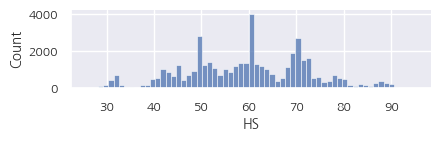

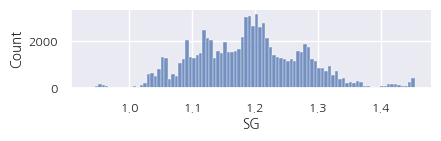

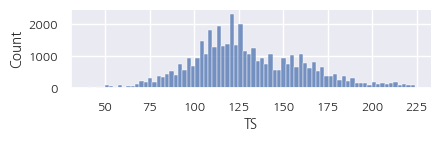

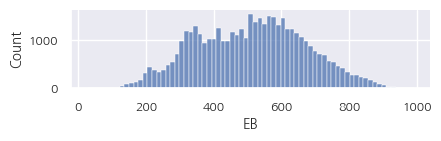

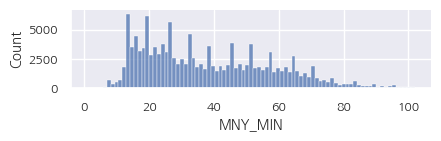

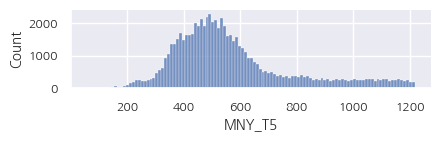

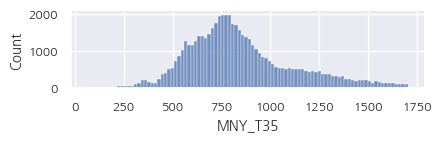

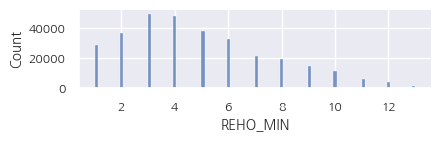

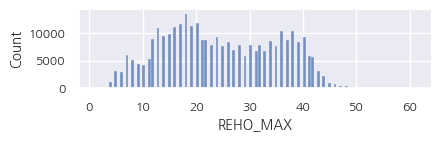

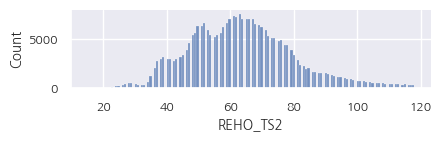

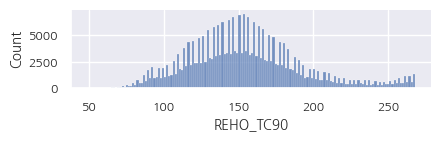

In [26]:
trg_regression_cols = ['HS','SG','TS','EB','MNY_MIN','MNY_T5','MNY_T35','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90']
trg_classification_cols = [] #['HS_RESULT','SG_RESULT','TS_RESULT','EB_RESULT','MNY_RESULT','REHO_RESULT','SCR_RESULT']
trg_cols = trg_regression_cols + trg_classification_cols
for yCol in trg_cols:
    sns.displot(mes_full_df[yCol], height=1.5, aspect=3)